In [3]:
import pandas as pd
import sys
sys.path.append('../src') 
from data_loader import ChestXray8Dataset
from models.cnn import ResNet50
import time
import torch.optim as optim
import torch.nn as nn
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm # Progession bar

# Configuration settings
data_dir = Path.cwd().parent / 'data'
images_dir = data_dir / 'images'
metadata_dir = data_dir /'metadata'/ 'Data_Entry_2017_v2020.csv'
train_list_path = data_dir /'metadata'/ 'train_val_list.txt'
test_list_path = data_dir / 'metadata' /'test_list.txt'
transform = transforms.Compose([
    transforms.Resize((224, 224)),             # Redimensionar a 224x224
    transforms.ToTensor(),                     # Convertir a tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalización
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
train_dataset = ChestXray8Dataset(
    img_dir=images_dir, 
    metadata_file=metadata_dir, 
    split_file=train_list_path,
    mode='train',  # Training mode
    transform=transform
)
test_dataset = ChestXray8Dataset(
    img_dir=images_dir, 
    metadata_file=metadata_dir, 
    split_file=test_list_path,
    mode='test',  # Training mode
    transform=transform
)
train_loader =  DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Modelo


In [5]:
import torch.nn as nn
from torchvision.models import resnet50

class ChestXRayCNN(nn.Module):
    def __init__(self, num_classes=14, pretrained=True):
        super(ChestXRayCNN, self).__init__()
        self.base_model = resnet50(pretrained=pretrained)
        
        # Adaptar la última capa a multilabel y añadir Dropout
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Dropout(0.5),  # Dropout agregado
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)


## Config general

In [6]:
model = ChestXRayCNN(num_classes=14,pretrained=True).to(device)
criterion = nn.BCEWithLogitsLoss()  # Multilabel
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or (self.best_loss - val_loss > self.min_delta):
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

c:\Users\MEDHYCON\anaconda3\envs\tfm_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MEDHYCON\anaconda3\envs\tfm_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Métricas

In [7]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
def calculate_metrics(y_true, y_pred, threshold=0.5):
    y_pred_binary = (y_pred > threshold).astype(int)
    metrics = {
        "AUC": roc_auc_score(y_true, y_pred, average="macro", multi_class="ovr"),
        "F1": f1_score(y_true, y_pred_binary, average="macro"),
        "Precision": precision_score(y_true, y_pred_binary, average="macro"),
        "Recall": recall_score(y_true, y_pred_binary, average="macro"),
    }
    return metrics

## Entrenamiento

In [8]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    all_labels = []
    all_preds = []

    pbar = tqdm(loader, desc="Training", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        all_labels.append(labels.cpu().numpy())
        all_preds.append(torch.sigmoid(outputs).detach().cpu().numpy())

        pbar.set_postfix({"loss": loss.item()})

    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)

    metrics = calculate_metrics(all_labels, all_preds)
    return epoch_loss / len(loader), metrics

## Evaluación

In [9]:
def evaluate(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        pbar = tqdm(loader, desc="Evaluating", leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()

            all_labels.append(labels.cpu().numpy())
            all_preds.append(torch.sigmoid(outputs).cpu().numpy())

    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)

    metrics = calculate_metrics(all_labels, all_preds)
    return epoch_loss / len(loader), metrics


In [10]:
# Función de entrenamiento
def train_model(model, train_loader, val_loader, epochs, optimizer, criterion, scheduler, device):
    history = {"train_loss": [], "val_loss": []}
    early_stopping = EarlyStopping(patience=5, min_delta=1e-4)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Entrenamiento
        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        history["train_loss"].append(train_loss)

        # Validación
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        history["val_loss"].append(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Actualizar scheduler
        scheduler.step(val_loss)

        # Early Stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered. Stopping training.")
            break

    return history


In [13]:
epochs = 10
print(device)
history = train_model(model, train_loader, test_loader, epochs, optimizer, criterion,scheduler, device)

cuda
Epoch 1/10


Training:   0%|          | 0/2704 [00:00<?, ?it/s]

Validation:   0%|          | 0/800 [00:00<?, ?it/s]

Train Loss: 0.1600, Val Loss: 0.2616
Epoch 2/10


Training:   0%|          | 0/2704 [00:00<?, ?it/s]

Validation:   0%|          | 0/800 [00:00<?, ?it/s]

Train Loss: 0.1556, Val Loss: 0.2405
Epoch 3/10


Training:   0%|          | 0/2704 [00:00<?, ?it/s]

Validation:   0%|          | 0/800 [00:00<?, ?it/s]

Train Loss: 0.1541, Val Loss: 0.2415
Epoch 4/10


Training:   0%|          | 0/2704 [00:00<?, ?it/s]

Validation:   0%|          | 0/800 [00:00<?, ?it/s]

Train Loss: 0.1533, Val Loss: 0.2365
Epoch 5/10


Training:   0%|          | 0/2704 [00:00<?, ?it/s]

Validation:   0%|          | 0/800 [00:00<?, ?it/s]

Train Loss: 0.1529, Val Loss: 0.2399
Epoch 6/10


Training:   0%|          | 0/2704 [00:00<?, ?it/s]

: 

: 

In [20]:
import json

# Serialize data into file:
json.dump( history, open( "output_multilabel/resnet50_2.json", 'w' ) )

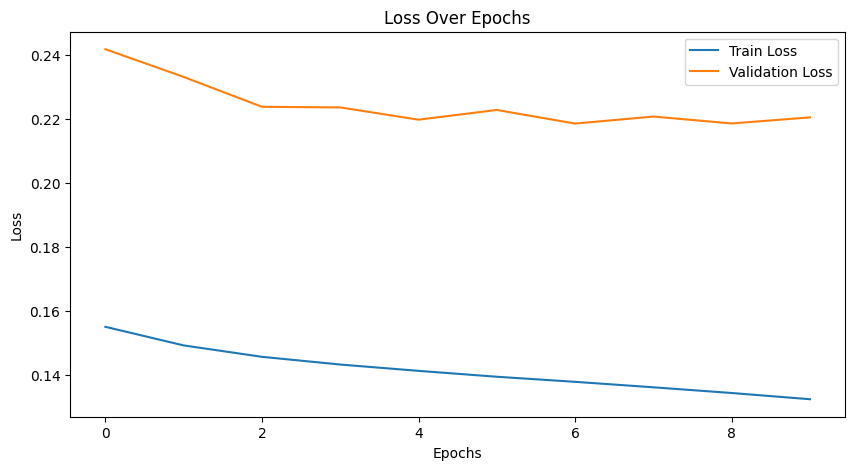

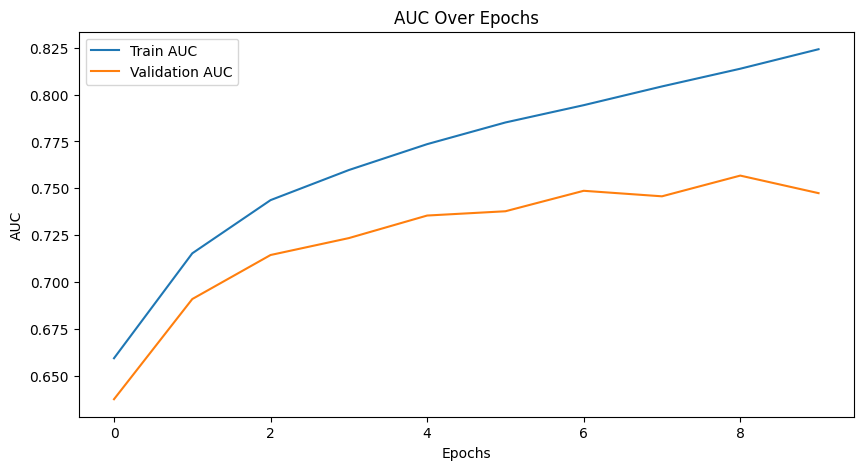

In [21]:
import matplotlib.pyplot as plt

# Pérdida
plt.figure(figsize=(10, 5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.show()

# Métricas (puedes ajustar según tus métricas)
plt.figure(figsize=(10, 5))
plt.plot([m["AUC"] for m in history["train_metrics"]], label="Train AUC")
plt.plot([m["AUC"] for m in history["val_metrics"]], label="Validation AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.title("AUC Over Epochs")
plt.legend()
plt.show()


In [22]:
test_loss, test_metrics = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Metrics: {test_metrics}")


Evaluating:   0%|          | 0/800 [00:00<?, ?it/s]